In [1]:
import autograd.numpy as np
from autograd import grad
import cvxpy as cp
import matplotlib.pyplot as plt

# 1) Data

- We will use real-world demographic data taken from LandScan [1].


- The desired information pertaining to the population of the city of Rio de Janeiro has been extracted by the ModSiming team from UFRJ [2].

[1] https://landscan.ornl.gov/

[2] https://github.com/ModSiming/EpiSiming

In [2]:
landscan_rio = np.load('landscan_rio_paqueta.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)
landscan_rio_xscale = 0.85239
landscan_rio_yscale = 0.926
landscan_rio_ydim, landscan_rio_xdim = landscan_rio.shape

print(f'Block matrix dimension: {landscan_rio.shape}')
print(f'Total blocks: {landscan_rio_xdim*landscan_rio_ydim}')
print(f'Total inhabited blocks: {len(landscan_rio[landscan_rio>0])}')

Block matrix dimension: (39, 83)
Total blocks: 3237
Total inhabited blocks: 1473


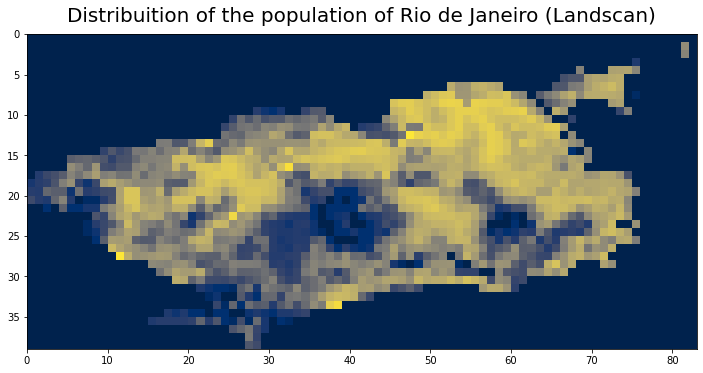

In [3]:
landscan_rio_plot = landscan_rio
landscan_rio_plot[np.where(landscan_rio == np.sort(landscan_rio.ravel())[-1])] = np.sort(landscan_rio.ravel())[-2]
landscan_rio_plot = np.log(1 + landscan_rio_plot) + 0.000_1*landscan_rio_plot

plt.figure(figsize = (12,6))
ext = [0, landscan_rio_xdim, landscan_rio_ydim, 0]
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.title("Distribuition of the population of Rio de Janeiro (Landscan)", fontsize = 20, y = 1.02);

# 2) Linear signal decay (concave objective function)

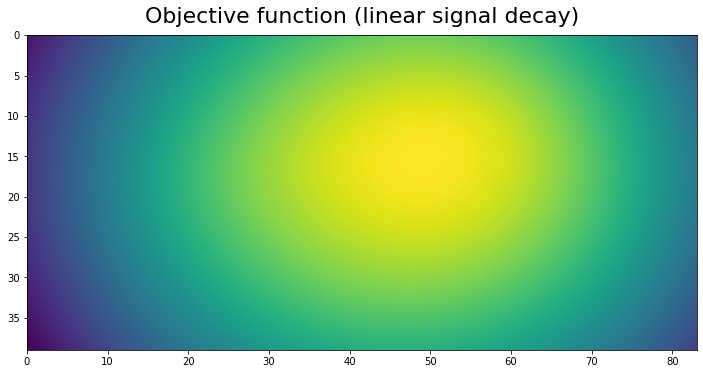

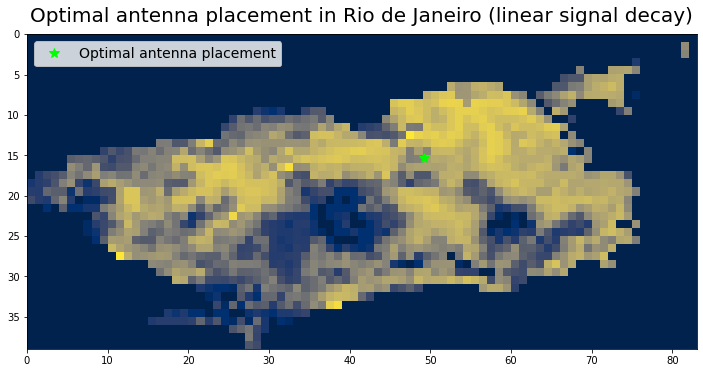

In [4]:
pts_x = np.arange(landscan_rio_xdim)
pts_y = np.arange(landscan_rio_ydim)
pts_x_meshgrid, pts_y_meshgrid = np.meshgrid(pts_x, pts_y)
all_pts = np.column_stack((pts_x_meshgrid.ravel(), pts_y_meshgrid.ravel()))

landscan_rio_flat = landscan_rio.ravel()

all_pts = all_pts[landscan_rio_flat > 0]
landscan_rio_flat = landscan_rio_flat[landscan_rio_flat > 0]

xy_scale = np.diag([landscan_rio_xscale, landscan_rio_yscale])

def d_to_all_pts(v): return np.linalg.norm((all_pts - v) @ xy_scale, axis = 1)
def s(d): return -d

def f_obj(v): return s(d_to_all_pts(v)) @ landscan_rio_flat

M = 200
N = 200
X = np.linspace(0, landscan_rio_xdim, M)
Y = np.linspace(0, landscan_rio_ydim, N)

F = np.reshape([f_obj(np.array([x,y])) for y in Y for x in X], (M,N))

plt.figure(figsize=(12,6))
plt.imshow(F, extent = ext)
plt.title("Objective function (linear signal decay)", fontsize = 22, y = 1.02);
plt.plot()

var = cp.Variable(2)

res_x_1 = (var[0] >= 0); res_x_2 = (var[0] <= landscan_rio_xdim-1)
res_y_1 = (var[1] >= 0); res_y_2 = (var[1] <= landscan_rio_ydim-1)
res = [res_x_1, res_x_2, res_y_2, res_y_2]

def d_to_all_pts(v): return cp.norm((all_pts - np.ones_like(all_pts) @ cp.diag(v)) @ xy_scale, axis = 1)
f_obj =  s(d_to_all_pts(var)) @ landscan_rio_flat

pb = cp.Problem(cp.Maximize(f_obj), res)
pb.solve()

loc_opt_lin = np.array(var.value)

plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_lin[0], loc_opt_lin[1], '*', color = 'lime', markersize = 10, label = "Optimal antenna placement")
plt.title("Optimal antenna placement in Rio de Janeiro (linear signal decay)", fontsize = 20, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);

# 3) Exponential signal decay (non-convex/concave objetive funtion)

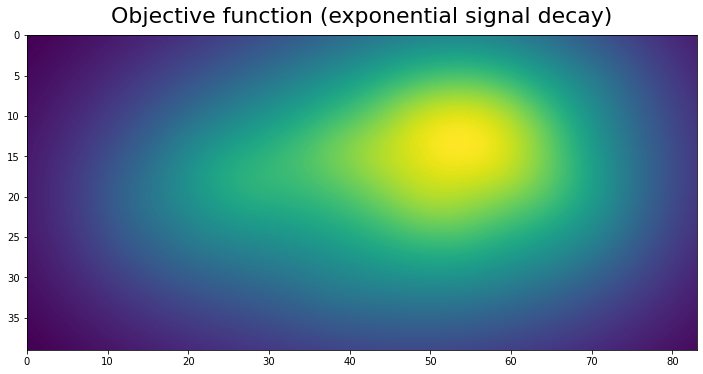

In [5]:
def d_to_all_pts(v): return np.linalg.norm((all_pts - v) @ xy_scale, axis = 1)
#c = 0.25
c = 0.1
def s(d): return np.exp(-c*d)

def f_obj(v): return s(d_to_all_pts(v)) @ landscan_rio_flat
grad_f = grad(f_obj)

M = 200
N = 200
X = np.linspace(0, landscan_rio_xdim, M)
Y = np.linspace(0, landscan_rio_ydim, N)

F = np.reshape([f_obj(np.array([x,y])) for y in Y for x in X], (M,N))

plt.figure(figsize=(12,6))
plt.imshow(F, extent = ext)
plt.title("Objective function (exponential signal decay)", fontsize = 22, y = 1.02);

## 3.1) Concave approximations

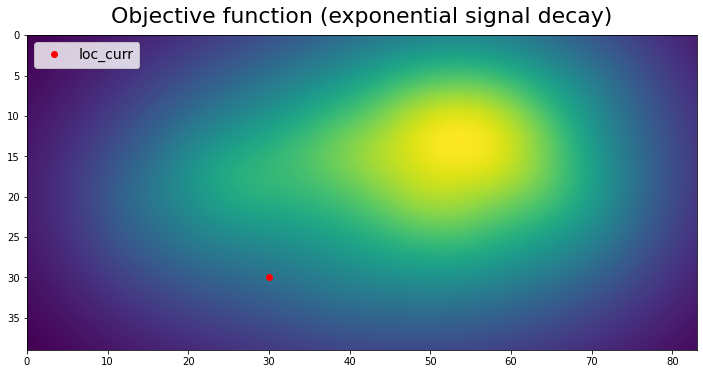

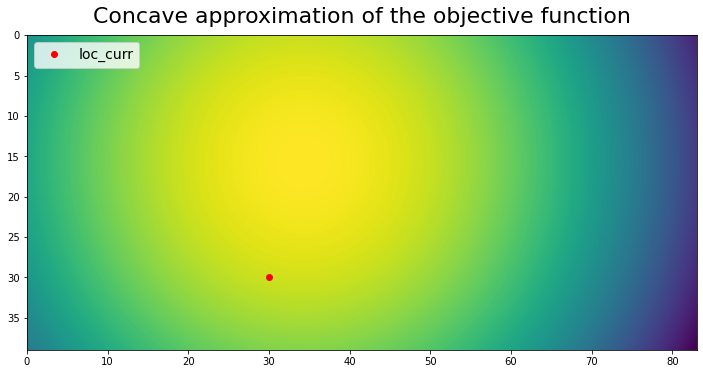

In [6]:
loc_curr = np.array([30.001, 30.001])

plt.figure(figsize=(12,6))
plt.imshow(F, extent = ext)
plt.plot(loc_curr[0], loc_curr[1], 'o', color = 'red', label = "loc_curr")
plt.title("Objective function (exponential signal decay)", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14)
plt.show()

f_obj_loc_curr = f_obj(loc_curr)
grad_f_loc_curr = grad_f(loc_curr)
R = 2_000.

def f_ccv_approx(v): return f_obj_loc_curr + grad_f_loc_curr@(v - loc_curr) - R*np.inner(v - loc_curr, v - loc_curr)
A = np.reshape([f_ccv_approx(np.array([x,y])) for y in Y for x in X], (N,M))

plt.figure(figsize=(12,6))
plt.imshow(A, extent = ext)
plt.plot(loc_curr[0], loc_curr[1], 'o', color = 'r', label = "loc_curr")
plt.title("Concave approximation of the objective function", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);

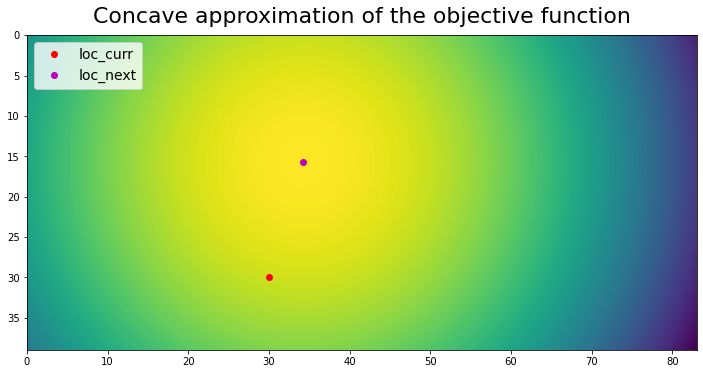

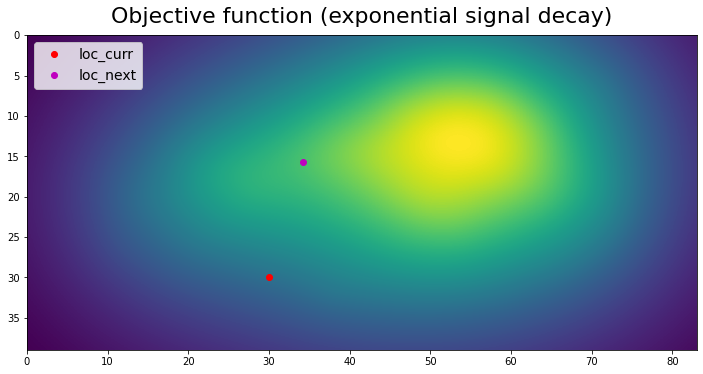

In [7]:
f_ccv_approx = f_obj_loc_curr + grad_f_loc_curr@(var - loc_curr) - R*cp.sum_squares(var - loc_curr)

pb = cp.Problem(cp.Maximize(f_ccv_approx), res)
pb.solve()

loc_next = np.array(var.value)

plt.figure(figsize=(12,6))
plt.imshow(A, extent = ext)
plt.plot(loc_curr[0], loc_curr[1], 'o', color = 'r', label = "loc_curr")
plt.plot(loc_next[0], loc_next[1], 'o', color = 'm', label = "loc_next")
plt.title("Concave approximation of the objective function", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14)
plt.show()

plt.figure(figsize=(12,6))
plt.imshow(F, extent = ext)
plt.plot(loc_curr[0], loc_curr[1], 'o', color = 'r', label = "loc_curr")
plt.plot(loc_next[0], loc_next[1], 'o', color = 'm', label = "loc_next")
plt.title("Objective function (exponential signal decay)", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);

C:\Users\Lima Freitas\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:167: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


len(locs) = 11


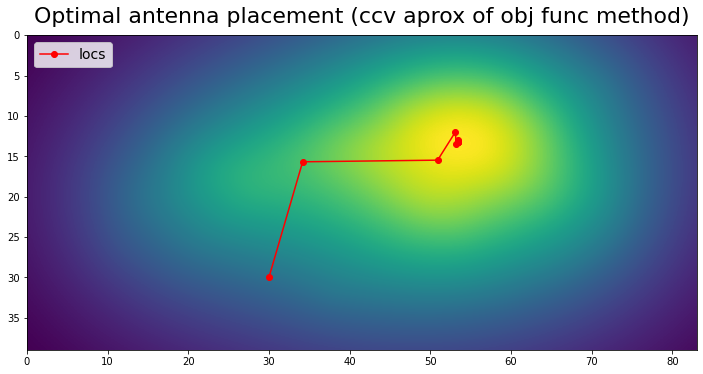

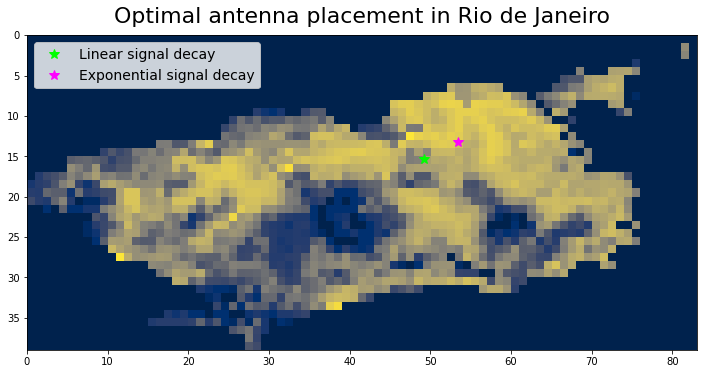

In [8]:
grad_f_loc_curr = cp.Parameter(2)
loc_curr = cp.Parameter(2)
R = cp.Parameter(nonneg = True)

f_ccv_approx = grad_f_loc_curr@(var - loc_curr) - R*cp.sum_squares(var - loc_curr)
pb = cp.Problem(cp.Maximize(f_ccv_approx), res)

loc_curr.value = [30.001, 30.001]
f_obj_loc_curr = f_obj(loc_curr.value)
grad_f_loc_curr.value = grad_f(loc_curr.value)
R.value = 2_000.
locs = np.array(loc_curr.value)

for i in range(1_000):
    pb.solve()
    loc_next = np.array(var.value)
    f_obj_loc_next = f_obj(loc_next)
    
    while f_obj_loc_next < f_obj_loc_curr:
        R.value = 2 * R.value
        pb.solve()
        loc_next = np.array(var.value)
        f_obj_loc_next = f_obj(loc_next)

    if np.linalg.norm(np.array(loc_curr.value) - loc_next) < 1e-3:
        break
    locs = np.vstack([locs, loc_next])
    f_obj_loc_curr = f_obj_loc_next
    grad_f_loc_curr.value = grad_f(loc_next)
    loc_curr.value = loc_next
    R.value = R.value / 2
    
print("len(locs) =", len(locs))

plt.figure(figsize=(12,6))
plt.imshow(F, extent = ext)
plt.plot(locs[:,0], locs[:,1], marker = 'o', color = 'r', label = "locs")
plt.title("Optimal antenna placement (ccv aprox of obj func method)", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14)
plt.plot()

loc_opt_exp = locs[-1]

plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_lin[0], loc_opt_lin[1], '*', color = 'lime', markersize = 10, label = "Linear signal decay")
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'fuchsia', markersize = 10, label = "Exponential signal decay")
plt.title("Optimal antenna placement in Rio de Janeiro", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);

## 3.2) Gradient "ascent"

len(locs) = 10


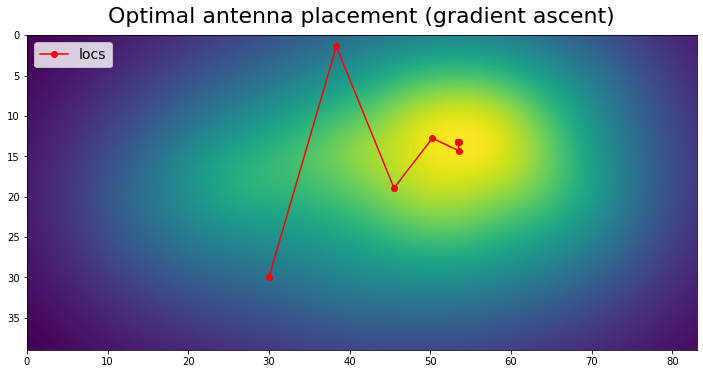

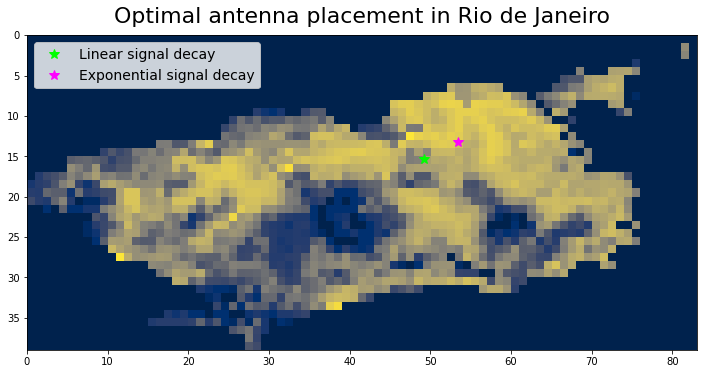

In [9]:
def f_obj(v):
    log_barrier = np.sum(np.log(np.hstack([v, np.array([landscan_rio_xdim, landscan_rio_ydim]) - v])))
    return s(d_to_all_pts(v)) @ landscan_rio_flat + log_barrier
grad_f = grad(f_obj)


loc_curr = np.array([30.001, 30.001])
f_obj_loc_curr = f_obj(loc_curr)
grad_f_loc_curr = grad_f(loc_curr)
λ = 1e-3
locs = loc_curr

for i in range(100):
    loc_next = loc_curr + λ*grad_f_loc_curr

    if np.any(np.hstack([loc_next, np.array([landscan_rio_xdim, landscan_rio_ydim] - loc_next)]) <= 0):
        f_obj_loc_next = -np.inf
    else:
        f_obj_loc_next = f_obj(loc_next)
    
    while f_obj_loc_next < f_obj_loc_curr:
        λ = λ/2
        loc_next = loc_curr + λ*grad_f_loc_curr
        
        if np.any(np.hstack([loc_next, np.array([landscan_rio_xdim, landscan_rio_ydim] - loc_next)]) <= 0):
            f_obj_loc_next = -np.inf
        else:
            f_obj_loc_next = f_obj(loc_next)
    
    if np.linalg.norm(loc_curr - loc_next) < 1e-3:
        break
        
    loc_curr = loc_next
    f_obj_loc_curr = f_obj_loc_next
    grad_f_loc_curr = grad_f(loc_curr)
    λ = λ*2
    
    locs = np.vstack([locs, loc_curr])
    
print("len(locs) =", len(locs))

plt.figure(figsize=(12,6))
plt.imshow(F, extent = ext)
plt.plot(locs[:,0], locs[:,1], marker = 'o', color = 'r', label = "locs")
plt.title("Optimal antenna placement (gradient ascent)", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14)
plt.plot()

loc_opt_exp = locs[-1]

plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_lin[0], loc_opt_lin[1], '*', color = 'lime', markersize = 10, label = "Linear signal decay")
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'fuchsia', markersize = 10, label = "Exponential signal decay")
plt.title("Optimal antenna placement in Rio de Janeiro", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);

# 4) Problem with N antennae 

In [10]:
def problem_N_antennae(loc_init, maxiters = 1_000, prec = 1e-3, return_all_locs = False):
    N = int(len(loc_init)/2)
    
    def f_obj(v):
        log_barrier = np.sum(np.log(np.hstack([v, np.array([landscan_rio_xdim, landscan_rio_ydim]*N) - v])))
        return s(np.min(np.vstack([d_to_all_pts(v[2*n:2*n+2]) for n in range(N)]), axis = 0)) @ landscan_rio_flat + log_barrier
    grad_f = grad(f_obj)
    
    loc_curr = loc_init
    locs = loc_curr
    f_obj_loc_curr = f_obj(loc_curr)
    f_objs = [f_obj_loc_curr]
    grad_f_loc_curr = grad_f(loc_curr)
    
    λ = 1.

    for i in range(maxiters):
        loc_next = loc_curr + λ*grad_f_loc_curr
        
        if np.any(np.hstack([loc_next, np.array([landscan_rio_xdim, landscan_rio_ydim]*N) - loc_next]) <= 0):
            f_obj_loc_next = -np.inf
        else:
            f_obj_loc_next = f_obj(loc_next)

        while f_obj_loc_next < f_obj_loc_curr:
            λ = λ/2
            loc_next = loc_curr + λ*grad_f_loc_curr
            
            if np.any(np.hstack([loc_next, np.array([landscan_rio_xdim, landscan_rio_ydim]*N) - loc_next]) <= 0):
                f_obj_loc_next = -np.inf
            else:
                f_obj_loc_next = f_obj(loc_next)       

        if np.linalg.norm(loc_curr - loc_next) < prec:
            break

        loc_curr = loc_next
        f_obj_loc_curr = f_obj_loc_next
        grad_f_loc_curr = grad_f(loc_curr)
        λ = λ*2

        locs = np.vstack([locs, loc_curr])
        f_objs += [f_obj_loc_curr]
    
    if return_all_locs:
        return locs, f_objs[-1]
    else:
        return locs[-1], f_objs[-1]

## 4.1) Problem with 2 antennae

In [11]:
loc_init_1 = np.array([75.001, 5.001])
loc_init_2 = np.array([30.001, 30.001])
loc_init = np.hstack([loc_init_1, loc_init_2])

locs, final_f_obj = problem_N_antennae(loc_init, return_all_locs = True)

In [12]:
len(locs)

26

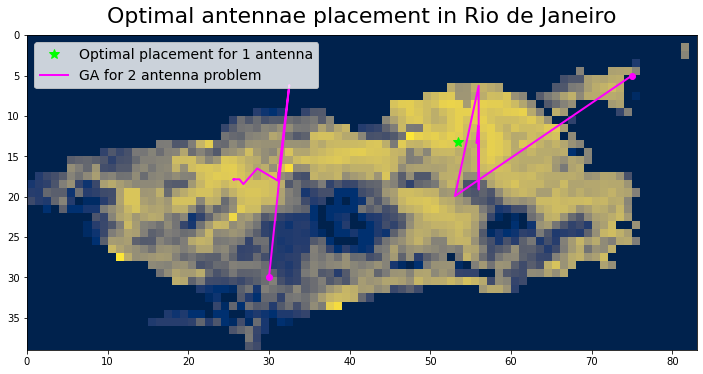

In [13]:
loc_opt_1_x = locs[:,0]
loc_opt_1_y = locs[:,1]
loc_opt_2_x = locs[:,2]
loc_opt_2_y = locs[:,3]

plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'lime', markersize = 10, label = "Optimal placement for 1 antenna")
plt.plot(loc_opt_1_x, loc_opt_1_y, color = 'fuchsia', lw = 2, label = "GA for 2 antenna problem")
plt.plot(loc_opt_2_x, loc_opt_2_y, color = 'fuchsia', lw = 2)
plt.plot(loc_opt_1_x[0], loc_opt_1_y[0], 'o', color = 'fuchsia')
plt.plot(loc_opt_2_x[0], loc_opt_2_y[0], 'o', color = 'fuchsia')
plt.title("Optimal antennae placement in Rio de Janeiro", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14)
plt.xlim(0, landscan_rio_xdim)
plt.ylim(landscan_rio_ydim, 0);

### 4.1.1) Multiple starting points

loc_opt = [55.87309174 13.19729516 25.64559583 17.85792642]


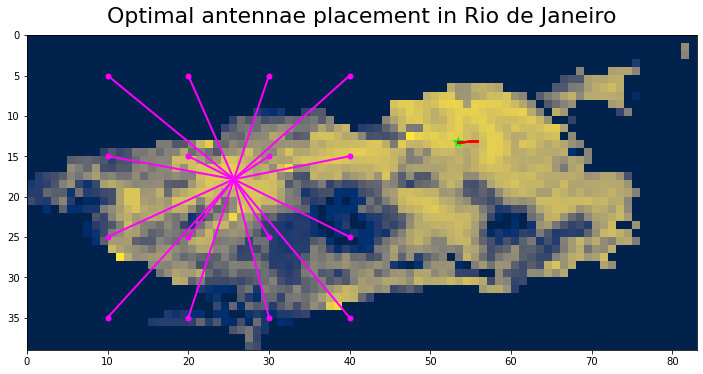

In [14]:
plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'lime', markersize = 10, label = "Optimal placement for 1 antenna")

init_xs = [10,20,30,40]
init_ys = [5,15,25,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

final_locs = []
final_f_objs = []

for loc_init_2 in zip(init_xs_meshgrid, init_ys_meshgrid):
    loc_init_1 = loc_opt_exp
    loc_init = np.hstack([loc_init_1, loc_init_2])
    
    final_loc, final_f_obj = problem_N_antennae(loc_init)
    
    final_locs += [final_loc]
    final_f_objs += [final_f_obj]
    
    plt.plot([loc_init[0], final_loc[0]], [loc_init[1], final_loc[1]], lw =2, color = 'red')
    plt.plot([loc_init[2], final_loc[2]], [loc_init[3], final_loc[3]], lw =2, color = 'fuchsia')
    plt.plot(loc_init[2], loc_init[3], 'o', markersize = 5, lw = 2, color = 'fuchsia')
    
loc_opt = final_locs[np.argmax(final_f_obj)]
print("loc_opt =", loc_opt)

plt.title("Optimal antennae placement in Rio de Janeiro", fontsize = 22, y = 1.02)
plt.xlim(0, landscan_rio_xdim)
plt.ylim(landscan_rio_ydim, 0);

loc_opt = [55.87309174 13.19729516 25.64559583 17.85792642]


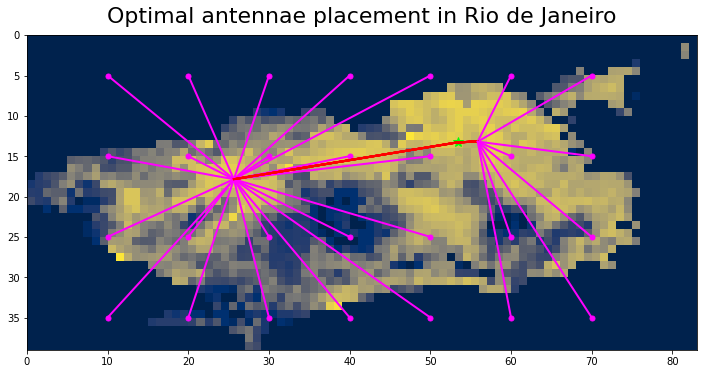

In [15]:
plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'lime', markersize = 10, label = "Optimal placement for 1 antenna")

init_xs = [10,20,30,40,50,60,70]
init_ys = [5,15,25,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

final_locs = []
final_f_objs = []

for loc_init_2 in zip(init_xs_meshgrid, init_ys_meshgrid):
    loc_init_1 = loc_opt_exp
    loc_init = np.hstack([loc_init_1, loc_init_2])
    
    final_loc, final_f_obj = problem_N_antennae(loc_init)
    
    final_locs += [final_loc]
    final_f_objs += [final_f_obj]
    
    plt.plot([loc_init[0], final_loc[0]], [loc_init[1], final_loc[1]], lw =2, color = 'red')
    plt.plot([loc_init[2], final_loc[2]], [loc_init[3], final_loc[3]], lw =2, color = 'fuchsia')
    plt.plot(loc_init[2], loc_init[3], 'o', markersize = 5, lw = 2, color = 'fuchsia')
    
loc_opt = final_locs[np.argmax(final_f_obj)]
print("loc_opt =", loc_opt)

plt.title("Optimal antennae placement in Rio de Janeiro", fontsize = 22, y = 1.02)
plt.xlim(0, landscan_rio_xdim)
plt.ylim(landscan_rio_ydim, 0);

loc_opt = [55.87262307 13.19758397 25.64465932 17.85691842]


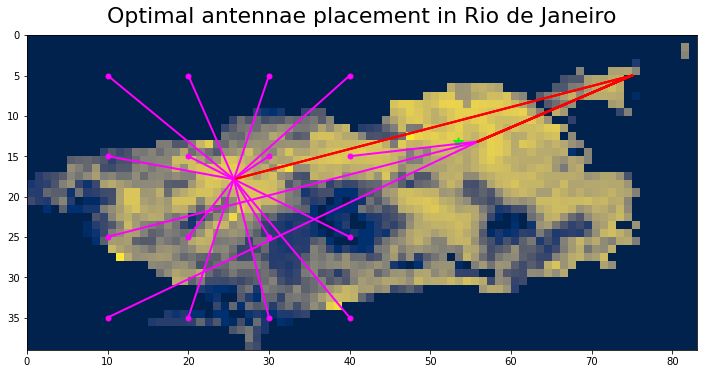

In [16]:
plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'lime', markersize = 10, label = "Optimal placement for 1 antenna")

init_xs = [10,20,30,40]
init_ys = [5,15,25,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

final_locs = []
final_f_objs = []

for loc_init_2 in zip(init_xs_meshgrid, init_ys_meshgrid):
    loc_init_1 = np.array([75.001, 5.001])
    loc_init = np.hstack([loc_init_1, loc_init_2])
    
    final_loc, final_f_obj = problem_N_antennae(loc_init)
    
    final_locs += [final_loc]
    final_f_objs += [final_f_obj]
    
    plt.plot([loc_init[0], final_loc[0]], [loc_init[1], final_loc[1]], lw =2, color = 'red')
    plt.plot([loc_init[2], final_loc[2]], [loc_init[3], final_loc[3]], lw =2, color = 'fuchsia')
    plt.plot(loc_init[2], loc_init[3], 'o', markersize = 5, lw = 2, color = 'fuchsia')
    
loc_opt = final_locs[np.argmax(final_f_obj)]
print("loc_opt =", loc_opt)

plt.title("Optimal antennae placement in Rio de Janeiro", fontsize = 22, y = 1.02)
plt.xlim(0, landscan_rio_xdim)
plt.ylim(landscan_rio_ydim, 0);

loc_opt_exp_2 = [25.64572796 17.85724888 55.87291654 13.19759667]


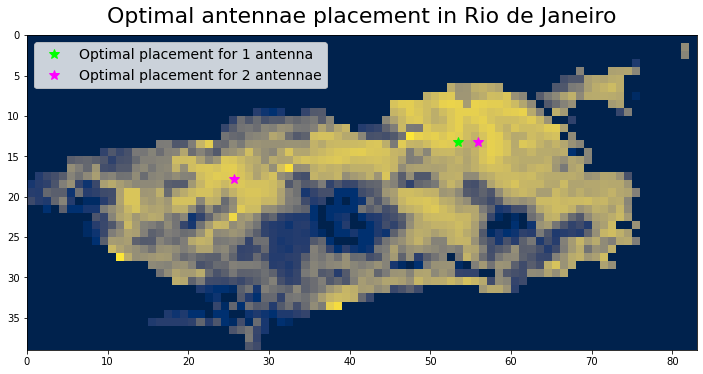

Wall time: 17.4 s


In [17]:
%%time

init_xs = [10,25,40,55,70]
init_ys = [5,15,25,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

final_locs = []
final_f_objs = []

for loc_init_1 in zip(init_xs_meshgrid, init_ys_meshgrid):
    for loc_init_2 in zip(init_xs_meshgrid, init_ys_meshgrid):
        loc_init = np.hstack([loc_init_1, loc_init_2])
        
        final_loc, final_f_obj = problem_N_antennae(loc_init)

        final_locs += [final_loc]
        final_f_objs += [final_f_obj]

loc_opt_exp_2 = final_locs[np.argmax(final_f_objs)]
print("loc_opt_exp_2 =", loc_opt_exp_2)

plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'lime', markersize = 10, label = "Optimal placement for 1 antenna")
plt.plot(loc_opt_exp_2[0], loc_opt_exp_2[1], '*', color = 'fuchsia', markersize = 10, label = "Optimal placement for 2 antennae")
plt.plot(loc_opt_exp_2[2], loc_opt_exp_2[3], '*', color = 'fuchsia', markersize = 10)
plt.title("Optimal antennae placement in Rio de Janeiro", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14)
plt.xlim(0, landscan_rio_xdim)
plt.ylim(landscan_rio_ydim, 0)
plt.show();

## 4.2) Problem with N>2 antennae

In [18]:
def plot_loc_opts(loc_opts, colors, markersize = 14):
    plt.figure(figsize=(12,6))
    plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
    
    for loc_opt, color in zip(loc_opts, colors):
        num_antennae = len(loc_opt[::2])
        #if num_antennae == 1:
        #    lbl = "Optimal placement for 1 antenna"
        #else:
        #    lbl = f"Optimal placement for {num_antennae} antennae"
        plt.plot(loc_opt[[2*i for i in range(num_antennae)]], loc_opt[[2*i+1 for i in range(num_antennae)]], '*',
                 markersize = markersize, color = color, markeredgecolor = 'black', label = f"$N = {num_antennae}$")
    
    plt.title("Optimal placement for $N$ antennae in Rio de Janeiro", fontsize = 22, y = 1.02)
    plt.legend(loc = 'upper left', fontsize = 10)
    plt.xlim(0, landscan_rio_xdim)
    plt.ylim(landscan_rio_ydim, 0)
    plt.show();

In [19]:
%%time

loc_opts = [loc_opt_exp]

init_xs = [10,20,30,40,50,60,70]
init_ys = [5,10,15,20,25,30,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

for n in range(2,31):
    final_locs = []
    final_f_objs = []

    for loc_init_new in zip(init_xs_meshgrid, init_ys_meshgrid):
        loc_init = np.hstack([loc_opts[-1], loc_init_new])

        final_loc, final_f_obj = problem_N_antennae(loc_init)

        final_locs += [final_loc]
        final_f_objs += [final_f_obj]

    loc_opt = final_locs[np.argmax(final_f_objs)]
    loc_opts += [loc_opt]

Wall time: 7min 7s


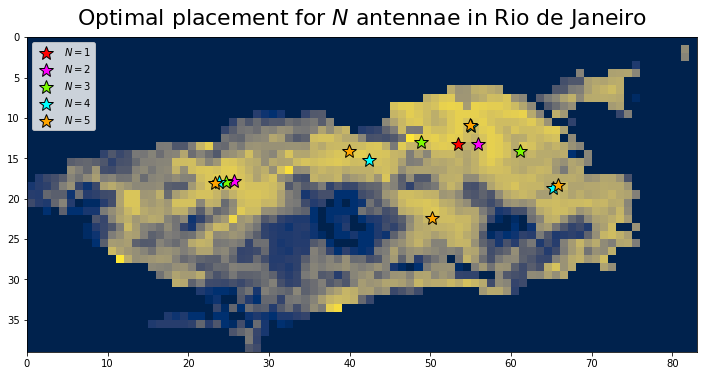

In [20]:
colors = ['red', 'fuchsia', 'lawngreen', 'cyan', 'orange']
plot_loc_opts(loc_opts[:5], colors)

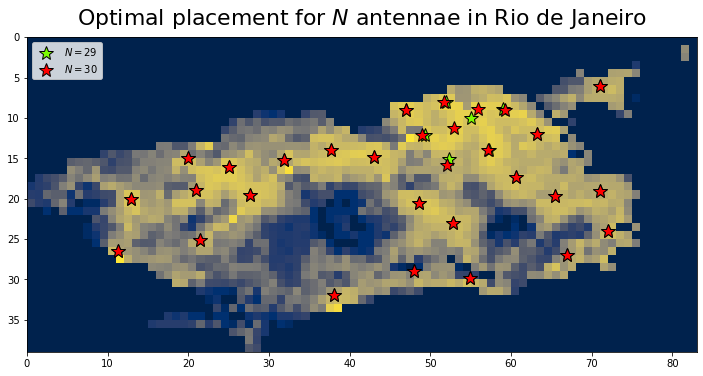

In [25]:
plot_loc_opts(loc_opts[-2:], colors = ['lawngreen', 'red'])